In [1]:
%load_ext autoreload
%autoreload 2

In [12]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import vice

# from surp.src.analysis import plotting_utils as pluto
from surp.src.analysis.apogee_analysis import subgiants
import arya
plt.rcParams["figure.dpi"] = 200

In [11]:
width = 3
ϕ = np.sqrt(2)
height = width/ϕ
arya.style.set_size((width, height))
#arya.style.set_fontsize(12)
arya.save_at("./figures")

one file saved at ./figures/subgiants_mgh.pdf


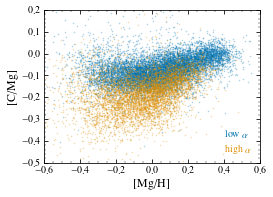

In [4]:
ha = subgiants["high_alpha"]

df = subgiants[~ha]

s = arya.Scatter(df["MG_H"], df["C_MG"], size=0.3, alpha=0.3)
s.label = "low $\\alpha$"

sp = s.subplot

df = subgiants[ha]
s1 = arya.Scatter(df["MG_H"], df["C_MG"], size=0.3, subplot=sp, alpha=0.3)
s1.label = "high $\\alpha$"


arya.Legend(sp)
sp.legend.ms = 2
cs = []
for c in sp.legend.colors:
    c1 = c
    c1[3] = 1
    cs.append(c1)
    
sp.legend.colors = cs
sp.legend.color_labels()
sp.legend.hide_handles()


sp.x.lim = (-0.6, 0.6)
sp.y.lim = (-0.5, 0.2)
sp.x.label = "[Mg/H]"
sp.y.label = "[C/Mg]"

sp.save("subgiants_mgh.pdf")

one file saved at ./figures/subgiants_mgfe.pdf


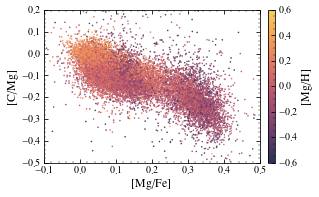

In [5]:
cmap = arya.style.get_cmap(reverse=False)
df = subgiants
s = arya.Scatter(df["MG_FE"], df["C_MG"], s=0.3, alpha=1, c=df["MG_H"], cmap=cmap)
s.clim = (-0.6, 0.6)
s.label = "high $\\alpha$"

sp = s.subplot
cb = arya.Colorbar(s, width=arya.Length(height*0.05))
cb.ax.label = "[Mg/H]"

sp.x.lim = (-0.1, 0.5)
sp.y.lim = (-0.5, 0.2)
sp.x.label = "[Mg/Fe]"
sp.y.label = "[C/Mg]"

sp.save("subgiants_mgfe.pdf")


In [6]:

Z_max = 0.04
Z_min = 0.0001
logZ_min = np.log10(Z_min/0.014)
logZ_max = np.log10(Z_max/0.014)

norm = mpl.colors.Normalize(logZ_min, logZ_max)
cmap = arya.style.get_cmap(reverse=False)
mpp = mpl.cm.ScalarMappable(norm, cmap)
ma = mpp.to_rgba

AGB_MODELS = ["cristallo11", "karakas10", "ventura13", "karakas16"]
AGB_LABELS = ["C11", "K10", "V13", "K16"]

# plt.rc('xtick.minor', visible=False)

def plot_c_table(study = "cristallo11", sp=None, label=None):

    y1, m1, z1 = vice.yields.agb.grid('c', study=study)
    N = len(z1)

    for i in range(N):
        y = np.array(y1)[:,i]
        z = z1[i]
        logz = np.log10(z) - np.log10(0.014)

        arya.Scatter(m1, y, label=f"Z = {z}", color=ma(logz), subplot=sp, zorder=i)
        arya.Line(m1, y, color=ma(logz), subplot=sp, zorder=i)

    plt.text(0.9, 0.9, label, horizontalalignment='right',
                   verticalalignment='top', transform=sp.mpl_ax.transAxes)
        # ax.set_xticks(np.arange(1, 8))
    
    # ax.axhline(0, color="k", ls="--", zorder=-1)



one file saved at ./figures/agb_yields.pdf


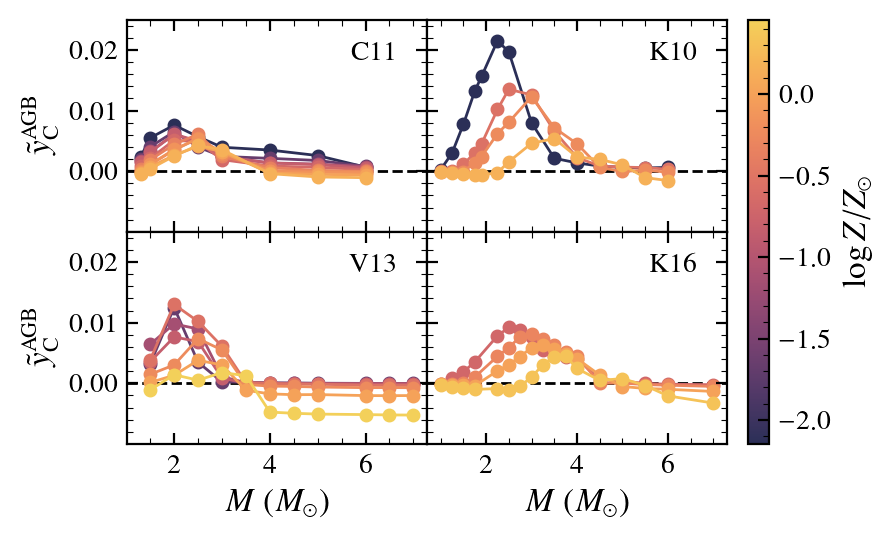

In [15]:
jp = arya.JoinPlot(2, 2, size=(width, height))

for i in range(4):
    sp = jp.children[i//2][i%2]
    sp.x.label = r"$M\ (M_{\odot})$"
    sp.y.label = r"$\tilde{y}_{\rm C}^{\rm AGB}$"
    study = AGB_MODELS[i]
    label = AGB_LABELS[i]
    plot_c_table(study=study, sp=sp, label=label)
    sp.mpl_ax.axhline(0, color="k", ls="--", zorder=-3)
    sp.y.lim = (-0.01, 0.025)
    sp.mpl_ax.set_yticks((0, 0.01, 0.02))
    
c = arya.Colorbar(subplot=jp, mappable = mpp, row=1, col=2, width=arya.Length(height*0.05))
c.ax.label = "$\log Z/Z_{\odot}$"

sp.save("agb_yields.pdf")

one file saved at ./figures/y_agb_vs_t.pdf


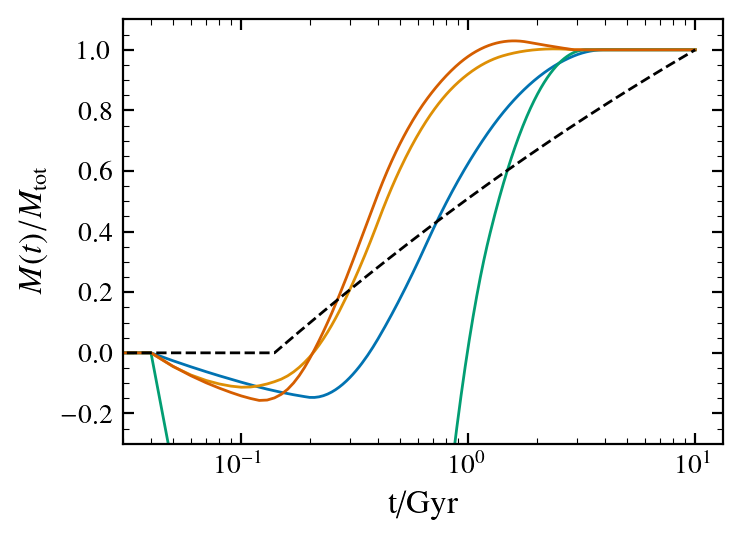

In [16]:
vice.yields.ccsne.settings["c"] = 0
vice.yields.sneia.settings["c"] = 0
vice.yields.ccsne.settings["fe"] = 0

sp = arya.Subplot()

for i in range(4):
    model = AGB_MODELS[i]
    vice.yields.agb.settings["c"] = model
    m_c, times = vice.single_stellar_population("c", Z=0.014 * 10**0)
    m_c = [c for c in m_c]
    arya.Line(times, np.array(m_c)/m_c[-1], subplot=sp)

m_fe, times = vice.single_stellar_population("fe", Z=0.014)
m_fe = [fe for fe in m_fe]
plt.plot(times, np.array(m_fe)/m_fe[-1], label="",
         linestyle="--", color="k")


plt.xlabel("t/Gyr")
plt.ylabel(r"$M(t)/M_{\rm tot}$")
plt.xscale("log")
plt.ylim(-0.3, 1.1)
plt.xlim(0.03, 13.2)
sp.save("y_agb_vs_t.pdf")

one file saved at ./figures/y_agb_vs_z.pdf


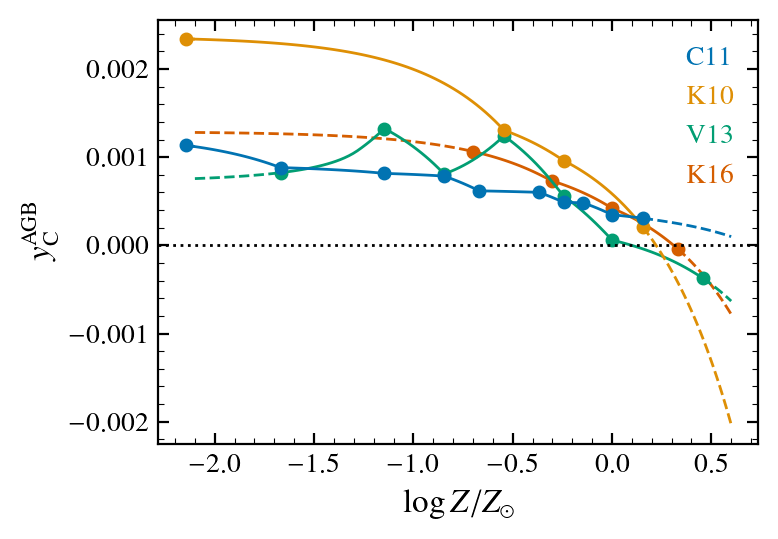

In [17]:
sp = arya.Subplot()

for i in range(len(AGB_MODELS)):
    model = AGB_MODELS[i]

    vice.yields.agb.settings["c"] = model
    vice.yields.ccsne.settings["c"] = 0
    Zs = 0.014*10**np.linspace(-2, 1, 100)
    
    # plots importaint points
    if type(model) == str:
        y1, m1, z1 = vice.yields.agb.grid('c', study=model)
        Zs = np.array(z1)
    mass_yields = []
    for Z in Zs:
        m_c, times = vice.single_stellar_population("c", Z=Z)
        mass_yields.append(m_c[-1])
        
    y_c_agb = np.array(mass_yields)/1e6 
    y_o_cc = 0.015
    arya.Scatter(np.log10(Zs/0.014), y_c_agb, subplot=sp, zorder=4-i)
    
    
    MoverH_min = np.log10(min(Zs)/0.014)
    MoverH_max = np.log10(max(Zs)/0.014)
    
    Zs = 0.014*10**np.linspace(MoverH_min, MoverH_max, 100)
    mass_yields = []
    for Z in Zs:
        m_c, times = vice.single_stellar_population("c", Z=Z)
        mass_yields.append(m_c[-1])
        
    l = arya.Line(np.log10(Zs/0.014), (np.array(mass_yields)/1e6 ), 
                  label=AGB_LABELS[i], subplot=sp, zorder=4-i)
    l.label = AGB_LABELS[i]

    Zs = 0.014*10**np.linspace(-2.1, MoverH_min, 100)
    mass_yields = []
    for Z in Zs:
        m_c, times = vice.single_stellar_population("c", Z=Z)
        mass_yields.append(m_c[-1])
    arya.Line(np.log10(Zs/0.014), (np.array(mass_yields)/1e6 ), linestyle="--", 
              color=l.color, subplot=sp, zorder=4-i)

    Zs = 0.014*10**np.linspace(MoverH_max, 0.6, 100)
    mass_yields = []
    for Z in Zs:
        m_c, times = vice.single_stellar_population("c", Z=Z)
        mass_yields.append(m_c[-1])
    arya.Line(np.log10(Zs/0.014), (np.array(mass_yields)/1e6 ), linestyle="--", 
              color=l.color, subplot=sp, zorder=4-i)

plt.axhline(0, color="k", ls=":")
plt.xlabel(r"$\log Z/Z_\odot$")
plt.ylabel(r"$y_\text{C}^\text{AGB}$")

leg = arya.Legend(sp, handlelength=0)
leg.hide_handles()
leg.color_labels()

sp.save("y_agb_vs_z.pdf")

In [7]:
# some studies have -inf values, which are ignored
allowed_MoverH = {
    "LC18": [-3, -2, -1, 0],
    "S16/N20": [0],
    "S16/W18": [0],
    "S16/W18F": [0],
    #"CL13": [0],
    "NKT13": [-np.inf, -1.15, -0.54, -0.24, 0.15, 0.55],
    #"CL04": [-np.inf, -4, -2, -1, -0.37, 0.15],
    "WW95": [-np.inf, -4, -2, -1, 0]
    }

allowed_rotations = {
    "LC18": [0, 150, 300],
    "S16/N20": [0],
    "S16/W18": [0],
    "S16/W18F": [0],
    "CL13": [0, 300],
    "NKT13": [0],
    "CL04": [0],
    "WW95": [0]
}

M_max = {
    "LC18": 120,
    "S16/N20": 120,
    "S16/W18": 120,
    "S16/W18F": 120,
    "NKT13": 40,
    "WW95": 40,
    "CL04": 35,
    "CL13": 120,
}

ccsne_studies = ["LC18", "S16/W18F", "S16/N20", "S16/W18", "NKT13", "WW95"]

colors = [arya.style.COLORS[i] for i in [0,1,1,1,2,3,4]]
markers = ["o", "s", "d", "D", "*", "^"]
sizes = [30, 30,30,10,30,30]
N = len(ccsne_studies)


def plot_analy():


    m_h = np.linspace(-0.6, 0.5, 1000)
    Z = 0.014*10**m_h
    plt.plot(m_h, y_c_cc(Z), color="k")
    
    m_h = np.linspace(-4, -0.6, 1000)
    Z = 0.014*10**m_h
    plt.plot(m_h, y_c_cc(Z), color="k", ls="-", zorder=-2, label="Analytic")

def plot_c11():
    vice.yields.agb.settings["c"] = "cristallo11"
    vice.yields.ccsne.settings["c"] = 0
    Zs = 0.014*10**np.linspace(-2, 1, 100)

    MoverH_min = np.log10(min(Zs)/0.014)
    MoverH_max = np.log10(max(Zs)/0.014)

    Zs = 0.014*10**np.linspace(MoverH_min, MoverH_max, 100)
    mass_yields = []
    for Z in Zs:
        m_c, times = vice.single_stellar_population("c", Z=Z)
        mass_yields.append(m_c[-1])
    line, = plt.plot(np.log10(Zs/0.014), (np.array(mass_yields)/1e6 ), label="C11 (AGB)", color=colors[-1])



In [8]:
def plot_y_cc(ele='c'):
    for i in range(N):
        study=ccsne_studies[i]
        metalicities = allowed_MoverH[study]
        rotations = allowed_rotations[study]
        m_upper = M_max[study]

        for j in range(len(rotations)):
            rotation = rotations[j]

            y = [vice.yields.ccsne.fractional(ele, study=study, MoverH=metalicity, 
                rotation=rotation, m_upper=m_upper)[0]
                 for metalicity in metalicities]

            marker = markers[i]
            color = colors[i]
            if np.isinf(metalicities[0]):
                if study == "WW95":
                    x0 = -4.5
                    y0 = -0.000
                    ms = 5
                    zorder = 2
                else:
                    x0 = -4.5
                    y0 = 0
                    ms = 6
                    zorder = 3
                plt.errorbar(x0, y[0] + y0, xerr=[0.2], fmt=marker, color=color, 
                             xuplims=[1],ms=ms, zorder=zorder, capsize=0)
                x = metalicities[1:]
                y = y[1:]
            else:
                x = metalicities

            if rotation == 150:
                linestyle="-"
                facecolor=(1,1,1,0)
                label=""
            elif rotation == 300:
                linestyle = ":"
                facecolor=(1,1,1,0)
                label=""
            else:
                linestyle="-"
                facecolor = color
                label=study
            
            plt.scatter(x, y, ec=color, label=label,
                        ls=linestyle, lw=1, fc=facecolor, 
                         marker=marker, s=sizes[i])


/tmp/slurmtmp.16640045/ipykernel_135150/2404430738.py:11: ScienceWarning: Woosley & Weaver (1995) did not report their birth abundances. VICE cannot compute net yields for this study, only reporting gross yields.
  y = [vice.yields.ccsne.fractional(ele, study=study, MoverH=metalicity,


one file saved at ./figures/y_mg.pdf


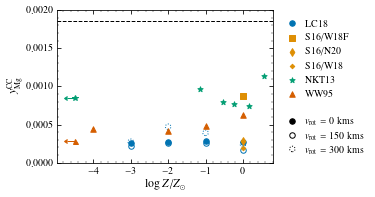

In [9]:
sp = arya.Subplot()
plot_y_cc('mg')
plt.axhline(0.00185, color="k", ls="--")
plt.xlabel("$\\log Z/Z_\\odot$")
plt.ylabel(r"$y_{\rm Mg}^{\rm CC}$")


l1 = plt.legend(bbox_to_anchor=(1,1), loc="upper left")


l = []
for i in range(3):
    l.append(plt.scatter(np.NaN, np.NaN, ls=["-", "-", ":"][i],
                ec="k", facecolor=["k", "white", "white"][i], lw=1, s=30,
                label=r"$v_{\rm rot}=%i$ kms" % ([0, 150, 300][i])
               ))
    


plt.legend(handles =l, bbox_to_anchor=(1,0.), loc="lower left")

plt.gca().add_artist(l1)
sp.y.lim = (0, 0.002)
sp.save("y_mg.pdf")

/tmp/slurmtmp.16626245/ipykernel_249642/2404430738.py:11: ScienceWarning: Woosley & Weaver (1995) did not report their birth abundances. VICE cannot compute net yields for this study, only reporting gross yields.
  y = [vice.yields.ccsne.fractional(ele, study=study, MoverH=metalicity,


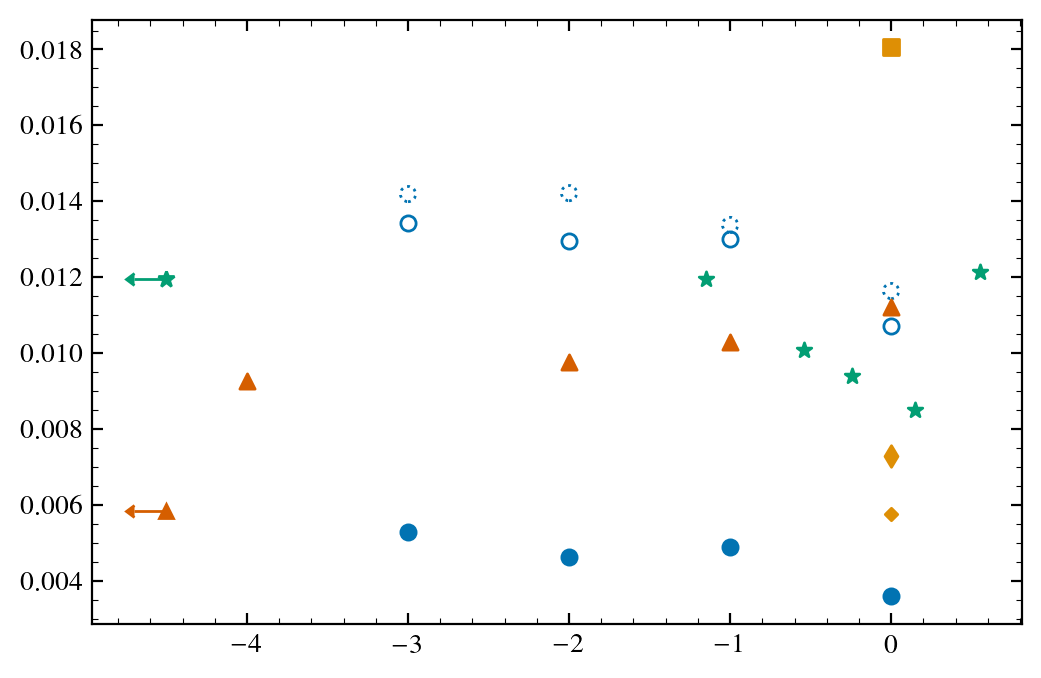

In [21]:
plot_y_cc('o')

In [26]:
def y_c_cc(Z):
    return 0.0028 + (Z/0.014)*0.001

/tmp/slurmtmp.16626245/ipykernel_249642/2404430738.py:11: ScienceWarning: Woosley & Weaver (1995) did not report their birth abundances. VICE cannot compute net yields for this study, only reporting gross yields.
  y = [vice.yields.ccsne.fractional(ele, study=study, MoverH=metalicity,


[-3, -2, -1, 0]
[-3, -2, -1, 0]
[-3, -2, -1, 0]
[0]
[0]
[0]
[-inf, -1.15, -0.54, -0.24, 0.15, 0.55]


/tmp/slurmtmp.16626245/ipykernel_249642/2412226995.py:34: ScienceWarning: Woosley & Weaver (1995) did not report their birth abundances. VICE cannot compute net yields for this study, only reporting gross yields.
  yc = [vice.yields.ccsne.fractional('c', study=study, MoverH=metalicity,
/tmp/slurmtmp.16626245/ipykernel_249642/2412226995.py:37: ScienceWarning: Woosley & Weaver (1995) did not report their birth abundances. VICE cannot compute net yields for this study, only reporting gross yields.
  yo = [vice.yields.ccsne.fractional('mg', study=study, MoverH=metalicity,


[-inf, -4, -2, -1, 0]
one file saved at ./figures/y_c_cc.pdf


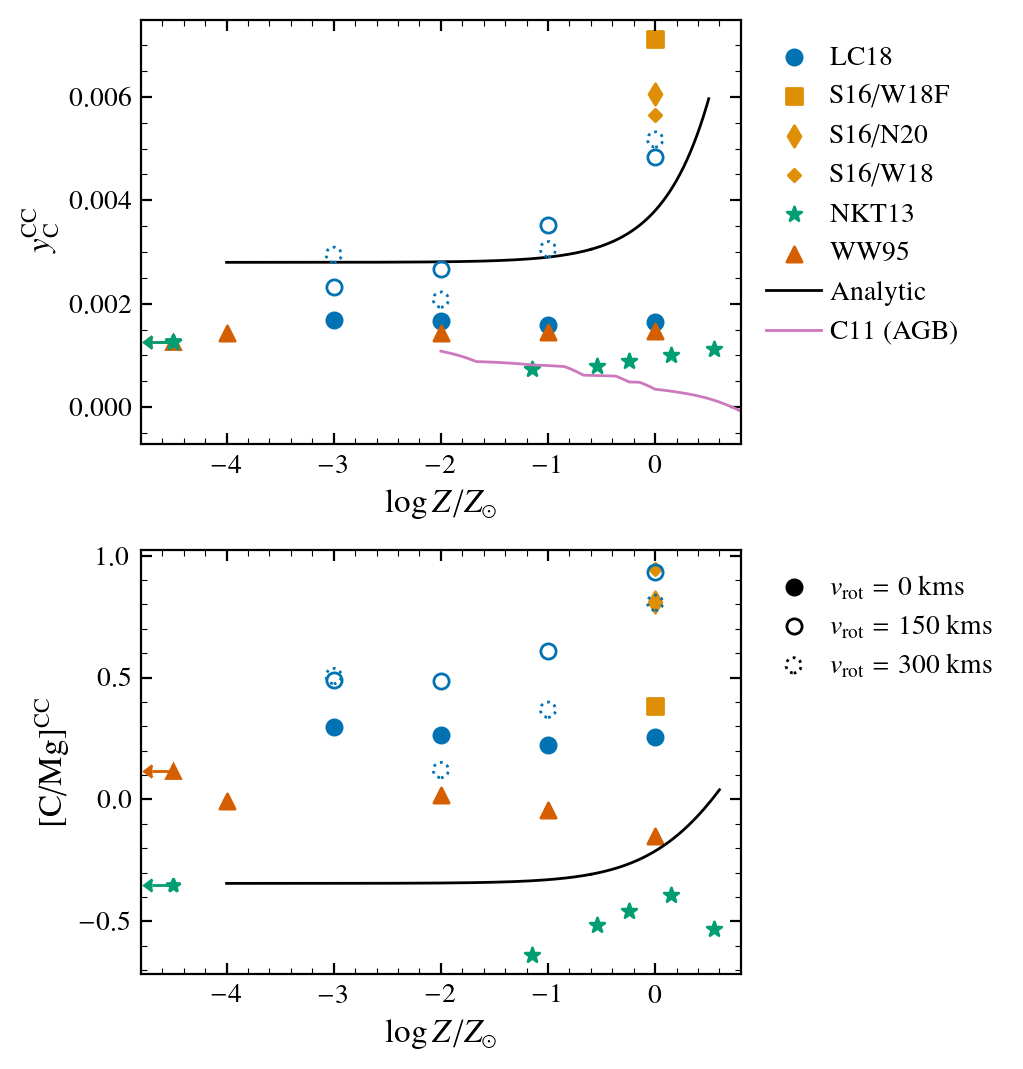

In [38]:



sp1 = arya.Subplot(pad=0.2)
sp = sp1.figure.add_subplot(row=1, col=0, pad=0.2)

plt.sca(sp.mpl_ax)

plot_y_cc()

plot_analy()
# plot AGB line

plot_c11()

plt.legend(bbox_to_anchor=(1,1), loc="upper left")




sp.x.label = r"$\log Z/Z_\odot$"
sp.y.label = r"$y_{\rm C}^{\rm CC}$"
sp.x.lim = (-4.8, 0.8)


plt.sca(sp1.mpl_ax)

for i in range(len(ccsne_studies)):
    study=ccsne_studies[i]
    metalicities = allowed_MoverH[study]

    rotations = allowed_rotations[study]
    m_upper = M_max[study]
    
    for j in range(len(rotations)):
        rotation = rotations[j]
        yc = [vice.yields.ccsne.fractional('c', study=study, MoverH=metalicity, 
            rotation=rotation, m_upper=m_upper)[0]
             for metalicity in metalicities]
        yo = [vice.yields.ccsne.fractional('mg', study=study, MoverH=metalicity, 
            rotation=rotation, m_upper=m_upper)[0]
              for metalicity in metalicities]
        y = np.log10(np.array(yc)/yo) - np.log10(vice.solar_z("c")/vice.solar_z("mg"))
                
        if i == 0 and j==2:
            pass
        print(metalicities)
      
        marker = markers[i]
        color = colors[i]
        if np.isinf(metalicities[0]):
            x0 = -4.5
            plt.errorbar(x0, y[0], xerr=[0.2], yerr=0, marker=marker, 
                         color=color, xuplims=[1], ms=5, capsize=0)
            x = metalicities[1:]
            y = y[1:]
        else:
            x = metalicities
        
        if rotation == 150:
            linestyle="-"
            facecolor=(1,1,1,0)
            label=""
            zorder = 2
        elif rotation == 300:
            linestyle = ":"
            facecolor=(1,1,1,0)
            label=""
            zorder = 3
        else:
            linestyle="-"
            facecolor = color
            label=study
            zorder = 1
        plt.scatter(x, y, edgecolors=color, label=label, zorder = zorder,
                    linestyle=linestyle, facecolors=facecolor, marker=marker, s=sizes[i])



m_h = np.linspace(-0.6, 0.6, 1000)
Z = 0.014*10**m_h
y = np.log10(y_c_cc(Z)/0.015) - np.log10(vice.solar_z("c")/vice.solar_z("o"))
plt.plot(m_h, y, color="k")

m_h = np.linspace(-4, -0.6, 1000)
Z = 0.014*10**m_h
y = np.log10(y_c_cc(Z)/0.015) - np.log10(vice.solar_z("c")/vice.solar_z("o"))
plt.plot(m_h, y, color="k", ls="-")


# final style things
plt.xlabel(r"$\log Z/Z_{\odot}$")
plt.ylabel(r"[C/Mg]$^\text{CC}$")
plt.xlim(-4.8, 0.8)





l = []
for i in range(3):
    l.append(plt.scatter(np.NaN, np.NaN, ls=["-", "-", ":"][i],
                ec="k", facecolor=["k", "white", "white"][i], lw=1, s=30,
                label=r"$v_{\rm rot}=%i$ kms" % ([0, 150, 300][i])
               ))
    
plt.legend(handles =l, bbox_to_anchor=(1,1.), loc="upper left")


sp.figure.update()

sp.figure.save("y_c_cc.pdf")

[-3, -2, -1, 0]
[-3, -2, -1, 0]
[-3, -2, -1, 0]
[0]
[0]
[0]
[-inf, -1.15, -0.54, -0.24, 0.15, 0.55]
[-inf, -4, -2, -1, 0]


/tmp/slurmtmp.16640045/ipykernel_135150/2186550757.py:22: ScienceWarning: Woosley & Weaver (1995) did not report their birth abundances. VICE cannot compute net yields for this study, only reporting gross yields.
  yc = [vice.yields.ccsne.fractional('o', study=study, MoverH=metalicity,
/tmp/slurmtmp.16640045/ipykernel_135150/2186550757.py:25: ScienceWarning: Woosley & Weaver (1995) did not report their birth abundances. VICE cannot compute net yields for this study, only reporting gross yields.
  yo = [vice.yields.ccsne.fractional('mg', study=study, MoverH=metalicity,


one file saved at ./figures/y_o_mg.pdf


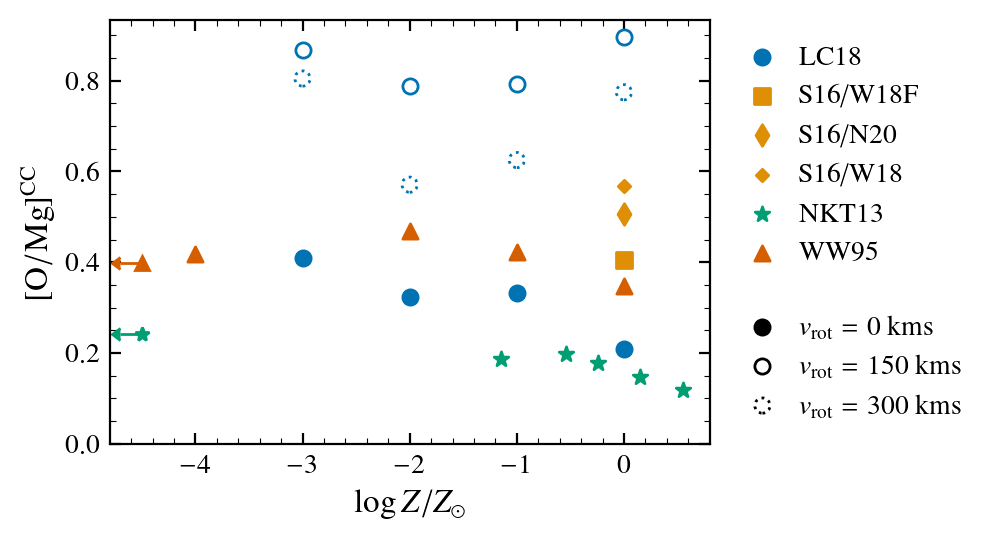

In [17]:



sp = arya.Subplot(pad=0.2)

plt.sca(sp.mpl_ax)


sp.x.label = r"$\log Z/Z_\odot$"
sp.y.label = r"$[{\rm O}/{\rm Mg}]^{\rm CC}$"
sp.x.lim = (-4.8, 0.8)


plt.sca(sp.mpl_ax)

for i in range(len(ccsne_studies)):
    study=ccsne_studies[i]
    metalicities = allowed_MoverH[study]

    rotations = allowed_rotations[study]
    m_upper = M_max[study]
    
    for j in range(len(rotations)):
        rotation = rotations[j]
        yc = [vice.yields.ccsne.fractional('o', study=study, MoverH=metalicity, 
            rotation=rotation, m_upper=m_upper)[0]
             for metalicity in metalicities]
        yo = [vice.yields.ccsne.fractional('mg', study=study, MoverH=metalicity, 
            rotation=rotation, m_upper=m_upper)[0]
              for metalicity in metalicities]
        y = np.log10(np.array(yc)/yo) - np.log10(vice.solar_z("o")/vice.solar_z("mg"))
                
        if i == 0 and j==2:
            pass
        print(metalicities)
      
        marker = markers[i]
        color = colors[i]
        if np.isinf(metalicities[0]):
            x0 = -4.5
            plt.errorbar(x0, y[0], xerr=[0.2], yerr=0, marker=marker, 
                         color=color, xuplims=[1], ms=5, capsize=0)
            x = metalicities[1:]
            y = y[1:]
        else:
            x = metalicities
        
        if rotation == 150:
            linestyle="-"
            facecolor=(1,1,1,0)
            label=""
            zorder = 2
        elif rotation == 300:
            linestyle = ":"
            facecolor=(1,1,1,0)
            label=""
            zorder = 3
        else:
            linestyle="-"
            facecolor = color
            label=study
            zorder = 1
        plt.scatter(x, y, edgecolors=color, label=label, zorder = zorder,
                    linestyle=linestyle, facecolors=facecolor, marker=marker, s=sizes[i])

# final style things
plt.xlabel(r"$\log Z/Z_{\odot}$")
plt.xlim(-4.8, 0.8)
plt.ylim(0)
leg1 = plt.legend(bbox_to_anchor=(1,1), loc="upper left")



l = []
for i in range(3):
    l.append(plt.scatter(np.NaN, np.NaN, ls=["-", "-", ":"][i],
                ec="k", facecolor=["k", "white", "white"][i], lw=1, s=30,
                label=r"$v_{\rm rot}=%i$ kms" % ([0, 150, 300][i])
               ))
    
leg2 = plt.legend(handles =l, bbox_to_anchor=(1,0.), loc="lower left")


sp.figure.update()
sp.mpl_ax.add_artist(leg1)

sp.figure.save("y_o_mg.pdf")

one file saved at ./figures/y_agb_t2.pdf


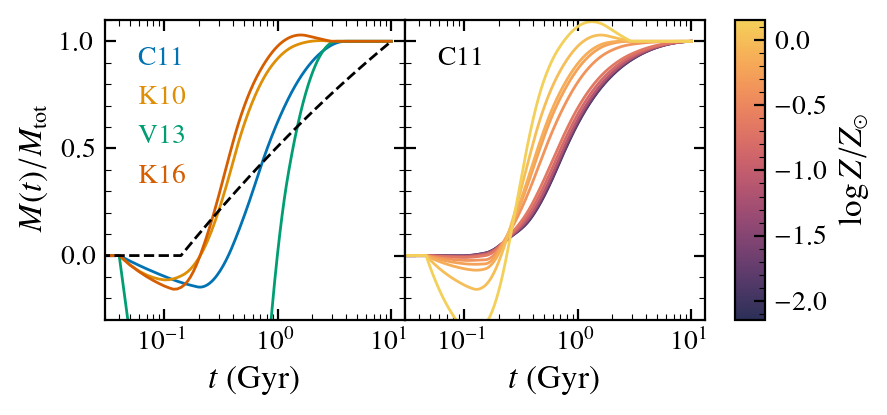

In [35]:
vice.yields.ccsne.settings["c"] = 0
vice.yields.sneia.settings["c"] = 0
vice.yields.ccsne.settings["fe"] = 0
cmap = arya.style.get_cmap()


model = "cristallo11"

_, _, z1 = vice.yields.agb.grid("c", model)
logZ_min = np.log10(min(z1)/0.014)
logZ_max = np.log10(max(z1)/0.014)

norm = mpl.colors.Normalize(logZ_min, logZ_max)

mpp = mpl.cm.ScalarMappable(norm, cmap)
ma = mpp.to_rgba


vice.yields.ccsne.settings["c"] = 0
vice.yields.sneia.settings["c"] = 0
vice.yields.ccsne.settings["fe"] = 0

jp = arya.JoinPlot(1, 2, size=(width, width/2))

sp = jp.children[0][0]
plt.sca(sp.mpl_ax)

for i in range(4):
    model = AGB_MODELS[i]
    vice.yields.agb.settings["c"] = model
    m_c, times = vice.single_stellar_population("c", Z=0.014 * 10**0)
    m_c = [c for c in m_c]
    l = arya.Line(times, np.array(m_c)/m_c[-1], subplot=sp, label=AGB_LABELS[i])
    l.label = AGB_LABELS[i]

m_fe, times = vice.single_stellar_population("fe", Z=0.014)
m_fe = [fe for fe in m_fe]
plt.plot(times, np.array(m_fe)/m_fe[-1], label="",
         linestyle="--", color="k")


plt.xlabel("$t$ (Gyr)")
plt.ylabel(r"$M(t)/M_{\rm tot}$")
plt.xscale("log")
plt.ylim(-0.3, 1.1)
plt.xlim(0.03, 13.2)

leg = arya.Legend(sp, handlelength=0)
leg.hide_handles()
leg.color_labels()



sp = jp.children[0][1]

plt.sca(sp.mpl_ax)
plt.xscale("log")
cmap = arya.style.get_cmap()
for i in range(len(z1)):
    z = z1[i]
    vice.yields.agb.settings["c"] = model
    m_c, times = vice.single_stellar_population("c", Z=z, dt=1e-3)
    m_c = [c for c in m_c]

    l = arya.Line(times, np.array(m_c)/m_c[-1], color=ma(np.log10(z/0.014)), subplot=sp)

plt.ylim(-0.3, 1.1)


c = arya.Colorbar(subplot=jp, mappable=mpp, row=1, col=2)
c.label = r"$\log Z/Z_\odot$"
sp.y.label = r"$M(t)/M_{\rm tot}$"
sp.x.label = "$t$ (Gyr)"
sp.x.lim = (0.03, 13.2)

sp.figure.update()

l = arya.Line([],[], subplot=sp)
l.label="C11"
arya.Legend(sp, handlelength=0)


sp.save("y_agb_t2.pdf")
